In [23]:
import torch
import numpy as np
import scipy as sp
import math
import copy
from matplotlib import pyplot as plt
from dataclasses import dataclass
from test_sampler import TestProblem

In [2]:
def nesterov(x_0, grad, L, mu, K):
    x_cur = x_0
    y_cur = x_0
    x_list = [x_0]
    y_list = [x_0]
    for i in range(K):
        x_upd = y_cur - (1/L)*(grad(y_cur, L))
        y_upd = x_upd + ((np.sqrt(L) - np.sqrt(mu))/(np.sqrt(L) + np.sqrt(mu))) * (x_upd - x_cur)


        x_list.append(x_upd)
        y_list.append(y_upd)

        x_cur = x_upd
        y_cur = y_upd

    return x_list, y_list

In [3]:
def grad_quad(x, L):
    A = np.array([[L,0],[0,1]])
    b = np.array([2,1])
    return A@x+b

In [4]:
# hyperparameters
# @dataclass
# class CFG:
#     x_0 = np.array([3, 1])
#     L = 100
#     K = 100000
#     mu = 1
# 
#     x_list_nes, y_list_nes = nesterov(x_0, grad_quad, L, mu, K)
# 
#     L_x = 10
#     L_y = 1000
#     mu_x = 0.1
#     mu_y = 0.1
#     A = np.array([[L_x, 0, 0, 0], [0, mu_x, 0, 0], [0, 0, L_y, 0], [0, 0, 0, mu_y]])
#     b = np.array([2, 1, 3, 1])
# 
#     # x_star = x_list_nes[-1]
#     x_star = np.linalg.solve(A, -b)
#     # x_0 = np.array([1, 2])
#     y_0 = np.array([2, 3])
#     n = 4
#     x_init = np.array(list(x_0) + list(y_0))
# 
#     d = 1 / 2 * (x_init.T @ A @ x_init + b.T @ x_init)
#     theta = np.linalg.norm(x_init - x_star)
#     alpha = 0.1
#     tau = 1 / (alpha * n * n + 1)
#     x_0 = np.array([3, 1])

In [5]:
test_problem = TestProblem()

/var/folders/n9/tgs43kxj3nz79q8g8t2qzzzw0000gn/T/ipykernel_4277/3051598060.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_problem.x = torch.tensor(x_upd, requires_grad=True)
/var/folders/n9/tgs43kxj3nz79q8g8t2qzzzw0000gn/T/ipykernel_4277/3051598060.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_problem.y = torch.tensor(y_upd, requires_grad=True)


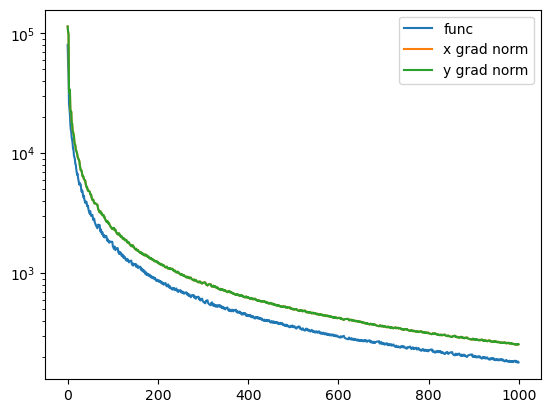

In [32]:
# ACRCD
history = []
grad_x_norms = []
grad_y_norms = []

def ACRCD(x_0, y_0, K):
    x_list = [x_0]
    y_list = [y_0]

    x_cur = x_0
    y_cur = y_0

    z_cur_x = x_0
    z_cur_y = y_0

    q_cur_x = x_0
    q_cur_y = y_0
    
    L_x = L_y = 5000
    beta = 2


    n_ =  L_x ** beta + L_y ** beta
    
    # q_cur (code) = y (paper)
    for i in range(K):
        
        #####  redefine alpha, tau
        alpha = (i + 2) / (2 * n_ ** 2)
        tau = 2 / (i + 2)
        
        x_upd = tau*z_cur_x+(1-tau)*q_cur_x
        y_upd = tau*z_cur_y+(1-tau)*q_cur_y
        
        test_problem.x = torch.tensor(x_upd, requires_grad=True)
        test_problem.y = torch.tensor(y_upd, requires_grad=True)
        result, grad_x, grad_y = test_problem.calc()
        history.append(result.item())
        grad_x_norms.append(torch.norm(grad_x).item())
        grad_y_norms.append(torch.norm(grad_y).item())
#         print(result, torch.norm(grad_x), torch.norm(grad_y))

        
        index_p = np.random.choice([0,1],p=[L_x ** beta / n_, 
                                            L_y ** beta / n_])
        
        if index_p == 0:
            q_upd_x = x_upd - (1/L_x)*grad_x
            q_upd_y = q_cur_y

        if index_p == 1:
            q_upd_y = y_upd - (1/L_y)*grad_y
            q_upd_x = q_cur_x

        if index_p == 0:
            z_upd_x = z_cur_x - (1/L_x)*alpha*n_*grad_x
            z_upd_y = z_cur_y

        if index_p == 1:
            z_upd_y = z_cur_y - (1/L_y)*alpha*n_*grad_y
            z_upd_x = z_cur_x



        x_list.append(x_upd)
        y_list.append(y_upd)

        x_cur = x_upd
        y_cur = y_upd

        z_cur_x = z_upd_x
        z_cur_y = z_upd_y

        q_cur_x = q_upd_x
        q_cur_y = q_upd_y


    return x_list, y_list


x_list_ACRCD, y_list_ACRCD = ACRCD(torch.rand(1000), torch.rand(2000, requires_grad=True), 1000)

# plt.plot(torch.log(torch.tensor(history)))

plt.plot(torch.tensor(grad_x_norms), label='func')
plt.plot(torch.tensor(grad_y_norms), label='x grad norm')
plt.plot(torch.tensor(grad_y_norms), label='y grad norm')
plt.yscale("log")
plt.legend()
plt.show()